In [68]:
import numpy as np
import random
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd

- sk=0: using_sklearn=False, sk=1: using_sklearn=True
- modele_gen=lineaire, sin ou tanh
- nb_train: nombre de donnees d'entrainement
- nb_test: nombre de donnees de test
- bruit: amplitude du bruit appliqué aux données
- M: degré du polynome de la fonction de base (recherche d'hyperparametre lorsque M<0) 
- lambda: lambda utilisé par le modele de Ridge ( learning rate)

In [69]:
skl = 1
modele_gen = "sin"
nb_train = 100
nb_test = 40
bruit = 0.3 # dispersion
m = 10
lamb = .001
w = [0.3, 4.1]  # Parametres du modele generatif

### Gestion Donnees

In [70]:
def generer_donnees():
    """
    Fonction qui genere des donnees de test et d'entrainement.

    modele_gen : 'lineaire', 'sin' ou 'tanh'
    nb_train : nb de donnees d'entrainement
    nb_test : nb de donnees de test
    bruit : amplitude du bruit (superieur ou egale a zero
    """
    np.random.seed(nb_train)
    x_train = np.random.rand(nb_train)
    x_test = np.random.rand(nb_test)
    if modele_gen == 'lineaire':
        t_train = w[0] + x_train * w[1] + np.random.randn(nb_train) * bruit
        t_test = w[0] + x_test * w[1] + np.random.randn(nb_test) * bruit
    elif modele_gen == 'sin':
        t_train = np.sin(x_train * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.sin(x_test * w[1] * 2) + np.random.randn(nb_test) * bruit
    else:
        t_train = np.tanh((x_train - 0.5) * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.tanh((x_test - 0.5) * w[1] * 2) + np.random.randn(nb_test) * bruit

    return x_train, t_train, x_test, t_test

In [71]:
def afficher_donnees_et_modele( x, t, scatter=True):
    """
    afficher des donnees

    x : vecteur de donnees
    t : vecteur de cibles
    scatter : variable determinant si on doit afficher une courbe ou des points
    """
    x_mod = np.arange(0, 1, 0.01)

    if modele_gen == 'lineaire':
        t_mod = w[0] + x_mod * w[1]
    elif modele_gen == 'sin':
        t_mod = np.sin(x_mod * w[1] * 2)
    else:
        t_mod = np.tanh((x_mod - 0.5) * w[1] * 2)

    if scatter is True:
        plt.scatter(x, t)
    else:
        idx = np.argsort(x)
        plt.plot(x[idx], t[idx], 'g')

    plt.plot(x_mod, t_mod, 'k')
    plt.ylim(ymin=-1.5, ymax=4.5)

### Regression

In [72]:
def fonction_base_polynomiale(x):
    """
    Fonction de base qui projette la donnee x vers un espace polynomial tel que mentionne au chapitre 3.
    Si x est un scalaire, alors phi_x sera un vecteur à M dimensions : (x^1,x^2,...,x^M)
    Si x est un vecteur de N scalaires, alors phi_x sera un tableau 2D de taille NxM

    NOTE : En mettant phi_x = x, on a une fonction de base lineaire qui fonctionne pour une regression lineaire
    """
    # AJOUTER CODE ICI
   
    try:
        # on place vecteur 1D dans un tableau 2D
        phi = x.reshape(-1, 1)
    except AttributeError:
        # erreur signifie problement qu'un int ou float a ete donnee
        phi = np.array([[x]])

    # creation d'un tableau 2D de taille NxM (x_0 = 1 non-inclus)
    for i in range(2, m + 1):
        phi = np.hstack((phi, (phi[:, 0] ** i).reshape((len(phi), 1))))
    phi = np.c_[np.ones(phi.shape[0]), phi]
    return phi

In [73]:
print("test fonction_base_polynomiale : avec m = 10")
print(" -> Si x est un scalaire : 2")
print("shape :"+str(fonction_base_polynomiale(2).shape))
pd.DataFrame(fonction_base_polynomiale(2))

test fonction_base_polynomiale : avec m = 10
 -> Si x est un scalaire : 2
shape :(1, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0,1024.0


In [74]:
print(" -> Si x est un vecteur de n scalaires : [2, 3]")
print("Shape :"+str(fonction_base_polynomiale(np.array([2, 3])).shape))
pd.DataFrame(fonction_base_polynomiale(np.array([2, 3])))

 -> Si x est un vecteur de n scalaires : [2, 3]
Shape :(2, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0,1024.0
1,1.0,3.0,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0,19683.0,59049.0


In [75]:
def recherche_hyperparametre(self, X, t):
        """
        Validation croisee de type "k-fold" pour k=10 utilisee pour trouver la meilleure valeur pour
        l'hyper-parametre self.M.
        Le resultat est mis dans la variable self.M
        X: vecteur de donnees
        t: vecteur de cibles
        """
        N = len(X)
        k = 10

        if N < k:
            raise AssertionError("Seulement {} valeurs pour validation-croisee {}-bloc. Impossible.".format(N, k))

        # On melange les indices de X/t pour une selection aleatoire des donnees
        melange = np.arange(0, N)
        np.random.shuffle(melange)

        # Liste de paires d'index permettant separation en k blocs
        selection = separation_k_blocs(N, k)

        # On scanne pour M = 1 à 10
        erreurs_moyenne = []
        for val_m in np.arange(1, 10, 1):
            m = val_m
            somme_err_valid = 0
            
            # On utilise chaque bloc séparément comme ensemble de validation
            for bloc in np.arange(0, k, 1):
                debut_valid, fin_valid = selection[bloc]
                
                # Listes des indices des donnees selectionnees
                train_indexes = np.concatenate((melange[0:debut_valid], melange[fin_valid:N]))
                valid_indexes = melange[debut_valid:fin_valid]

                # Entrainement puis validation
                self.entrainement(X[train_indexes], t[train_indexes])
                somme_err_valid += self.erreur(t[valid_indexes], self.prediction(X[valid_indexes]))

            erreurs_moyenne.append(somme_err_valid/k)

        # l'erreur moyenne minimale determine le meilleur M
        m = int(np.amin(erreurs_moyenne) + 1)

@staticmethod
def separation_k_blocs(N, k):
    """Retourne la liste d'index permettant de separer un vecteur de taille N en k blocs."""
    # On va avoir 'N%k' blocs de taille 'N//k + 1' et
    # 'k - N%k' blocs de taille 'N//k'
    taille_bloc = N // k
    nb_blocs_diff = N % k

    # Creation de la liste de selection d'index (index_debut, index_fin)
    bloc_courant = 0
    debut = 0
    selection = []

    # blocs de taille 'N//k + 1'
    while bloc_courant < nb_blocs_diff:
        fin = debut + taille_bloc + 1
        selection.append((debut, fin))
        debut = fin
        bloc_courant += 1

    # blocs de taille 'N//k'
    while bloc_courant < k:
        fin = debut + taille_bloc
        selection.append((debut, fin))
        debut = fin
        bloc_courant += 1

    return selection

In [76]:
def entrainement(X, t, using_sklearn=False):
    """
    Entraîne la regression lineaire sur l'ensemble d'entraînement forme des
    entrees ``X`` (un tableau 2D Numpy, ou la n-ieme rangee correspond à 
    l'entree x_n) et des cibles ``t`` (un tableau 1D Numpy ou le
    n-ieme element correspond à la cible t_n). L'entraînement doit
    utiliser le poids de regularisation specifie par ``lamb``.

    Cette methode doit assigner le champs ``w`` au vecteur
    (tableau Numpy 1D) de taille D+1, tel que specifie à la section 3.1.4
    du livre de Bishop.

    Lorsque using_sklearn=True, vous devez utiliser la classe "Ridge" de 
    la librairie sklearn (voir http://scikit-learn.org/stable/modules/linear_model.html)

    Lorsque using_sklearn=False, vous devez implementer l'equation 3.28 du
    livre de Bishop. Il est suggere que le calcul de ``w`` n'utilise
    pas d'inversion de matrice, mais utilise plutôt une procedure
    de resolution de systeme d'equations lineaires (voir np.linalg.solve).

    Aussi, la variable membre M sert à projeter les variables X vers un 
    espace polynomiale de degre M(voir fonction fonction_base_polynomiale())

    NOTE IMPORTANTE : lorsque M <= 0, il faut trouver la bonne valeur de M

    """
    #AJOUTER CODE ICI
    

    phi_x = fonction_base_polynomiale(X)
    #phi_x = np.c_[np.ones(phi_x.shape[0]), phi_x]
    phi_x = pd.DataFrame(phi_x)
    l = len(phi_x)
    w = np.array([0]*len(phi_x.columns))
    I = np.identity(len(phi_x.columns))
    
    # using_sklearn=True
    if(using_sklearn):
        reg = linear_model.Ridge(alpha=lamb)
        fit = reg.fit(phi_x, t)
        w = fit.coef_
    
    # using_sklearn=False
    else:  
        temp = lamb*I
        temp1 = np.dot(phi_x.T, phi_x)
        temp2 = temp + temp1
        w = np.linalg.solve(temp2, np.dot(phi_x.T, t)) # w=(λI+ΦTΦ)−1ΦTt.
        
    return w

In [77]:
def prediction(x):
    """
    Retourne la prediction de la regression lineaire
    pour une entree, representee par un tableau 1D Numpy ``x``.

    Cette methode suppose que la methode ``entrainement()``
    a prealablement ete appelee. Elle doit utiliser le champs ``w``
    afin de calculer la prediction y(x,w) (equation 3.1 et 3.3).
    """
    # AJOUTER CODE ICI
    x = fonction_base_polynomiale(x)
    x = np.c_[np.ones(x.shape[0]), x]
    y = W.T*x
    return np.sum(y, axis=1)

In [78]:
def erreur(t, prediction):
    """
    Retourne l'erreur de la difference au carre entre
    la cible ``t`` et la prediction ``prediction``.
    """
    # AJOUTER CODE ICI
    """ pas sure """
    return (t-prediction)**2

In [79]:
def warning(erreur_test, erreur_apprentissage, bruit):
    """
    Fonction qui affiche un WARNING à l'ecran lorsque les erreurs obtenues en fonction du bruit
    indique une possibilite de sur- ou de sous-apprentissage

    erreur_test: erreur obtenue sur l'ensemble de test
    erreur_apprentissage: erreur obtenue sur l'ensemble d'apprentissage
    bruit: magnitude du bruit
    """
    # AJOUTER CODE ICI
    

### Run

In [80]:
# Creer le gestionnaire de donnees et generer les donnees d'entraînement et de test
[x_train, t_train, x_test, t_test] = generer_donnees()

In [81]:
# Entrainement du modele de regression
W = entrainement(x_train, t_train, using_sklearn=False)

In [82]:
W

array([  0.10240483,   8.89118238, -27.77848669,   4.50036485,
        15.68309129,  11.17402182,   2.49253454,  -4.15471106,
        -6.56782956,  -4.58069578,   1.13527622])

In [83]:
# Predictions sur les ensembles 'entrainement et de test
predictions_train = np.array([prediction(x) for x in x_train])
predictions_test = np.array([prediction(x) for x in x_test])

ValueError: operands could not be broadcast together with shapes (11,) (1,12) 

In [64]:
# Calcul des erreurs
erreurs_entrainement = np.array([erreur(t_n, p_n)
                                 for t_n, p_n in zip(t_train, predictions_train)])
erreurs_test = np.array([erreur(t_n, p_n)
                         for t_n, p_n in zip(t_test, predictions_test)])

print("Erreur d'entraînement :", "%.2f" % erreurs_entrainement.mean())
print("Erreur de test :", "%.2f" % erreurs_test.mean())
print("")

warning(erreurs_test.mean(), erreurs_entrainement.mean(), bruit)

Erreur d'entraînement : 0.10
Erreur de test : 0.11



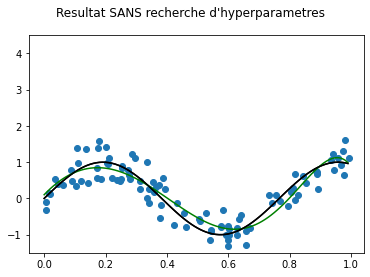

In [65]:
afficher_donnees_et_modele(x_train, t_train, True)
predictions_range = np.array([prediction(x) for x in np.arange(0, 1, 0.01)])
afficher_donnees_et_modele(np.arange(0, 1, 0.01), predictions_range, False)

if m >= 0:
    plt.suptitle('Resultat SANS recherche d\'hyperparametres')
else:
    plt.suptitle('Resultat AVEC recherche d\'hyperparametres')
plt.show()

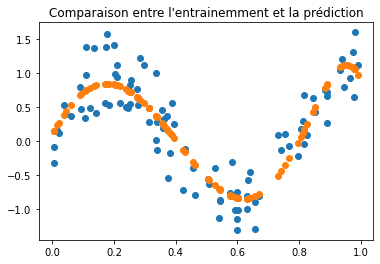

In [66]:
plt.figure()
plt.title("Comparaison entre l'entrainemment et la prédiction")
plt.scatter(x=x_train,y= t_train)           
plt.scatter(x=x_train, y=predictions_train)
plt.show()

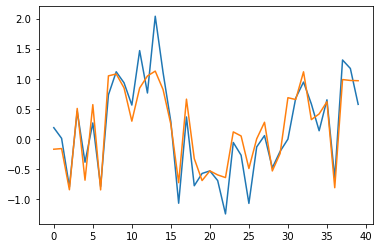

In [67]:
plt.figure()
plt.plot(t_test)
plt.plot(predictions_test)
plt.show()